In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def read_file(filename):
    return pd.read_csv(filename)

def get_data(timeframe):
    return read_file(r"C:\Users\ayush\Desktop\IITB\ZeltaLabPS\BackTesting\data\data\btcusdt_" + timeframe + "_val.csv")

time_frame = "1h"
# Load data
df = get_data(time_frame)
df.head()


datetime     open     high      low    close       volume
0  2020-07-24 23:30:00  9557.66  9589.00  9556.00  9580.01  1927.603117
1  2020-07-25 00:30:00  9580.00  9583.80  9560.00  9581.76  1236.182213
2  2020-07-25 01:30:00  9581.76  9620.00  9567.23  9615.29  2119.244392
3  2020-07-25 02:30:00  9615.32  9637.00  9588.08  9591.55  2088.164018
4  2020-07-25 03:30:00  9591.55  9593.46  9522.00  9533.92  2069.404213

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
import os
from numpy import dot
from numpy import sum, tile, linalg, log, pi, exp
from glob import glob
from numpy.linalg import inv, det
import math as m

In [55]:
class KalmanFilter:

    def __init__(self, df, tbs, initial_state_mean, initial_state_covariance, X, P, A, Q, B, U, R):
        """
        :param ohlc_data: dataframe with the columns mentioned above
        :param tbs: time between samples
        :param initial_state_mean: initial state mean
        :param initial_state_covariance: initial state covariance
        :param observation_covariance: observation covariance
        :param transition_covariance: transition covariance
        """
        self.df = df
        self.tbs = tbs
        self.initial_state_mean = initial_state_mean
        self.initial_state_covariance = initial_state_covariance
        self.initial_state_mean = initial_state_mean
        self.initial_state_covariance = initial_state_covariance
        self.counter = 0

        self.X = X
        self.P = P
        self.A = A
        self.Q = Q
        self.B = B
        self.U = U
        self.R = R
        self.H = np.eye(self.X.shape[0])
        self.K = np.zeros((self.X.shape[0], self.X.shape[0]))   
        self.Y = self.get_measurements()
        self.LH = [0, 0]

        # self.transition_matrices = transition_matrices
        # self.transition_offsets = transition_offsets
        # self.observation_matrices = observation_matrices
        # self.observation_offsets = observation_offsets
        # self.transition_covariance = transition_covariance
        # self.observation_covariance = observation_covariance
        

    def kalman_init(self):
        """
        This function will initialize the kalman filter
        """
        # self.X = np.array([[0.0], [0.0], [0.0], [0.0], [0.0]])
        # P is an array of 5x5 random values
        self.P = np.zeros((5, 5))

        # Fill the diagonal elements with random values between 0 and 1
        P = np.eye(self.X.shape[0])

        # Fill the off-diagonal elements with smaller random values
        for i in range(5):
            for j in range(5):
                if i != j:
                    self.P[i, j] = np.random.rand() * 0.1  # You can adjust the scale (0.1) as needed

        self.A = np.array([[0.5, 1, -0.5, 0, 0.1], 
                    [0.5, 1, -0.5, 0, 0.05],
                    [0.3, 1.5, -0.8, 0, 0.10],
                    [0, 0, 0, 1, 0],
                    [0, 0, 0, 0, 1]])
        self.Q = np.eye(self.X.shape[0]) * 0.1
        self.B = self.A * 0
        self.U = self.X * 0
        self.R = self.P
        
    def kf_predict(self):

        r"""Calculate the mean and covariance of :math:`P(x_{t+1} | z_{0:t})`

        Using the mean and covariance of :math:`P(x_t | z_{0:t})`, calculate the
        mean and covariance of :math:`P(x_{t+1} | z_{0:t})`.

        Returns
        -------
        predicted_state_mean : [n_dim_state] array
            mean of state at time t+1 given observations from times [0...t]
        predicted_state_covariance : [n_dim_state, n_dim_state] array
            covariance of state at time t+1 given observations from times
            [0...t]
        """

        self.X = dot(self.A, self.X) + dot(self.B, self.U)
        self.P = dot(self.A, dot(self.P, self.A.T)) + self.Q

        return(self.X, self.P) 
    


    def kf_pdf(self, M, S):
        if M.shape[1] == 1:
            # Tile M to match the shape of X
            DX = self.Y - np.tile(M, (1, self.Y.shape[1]))
            # Compute the exponential term
            E = 0.5 * np.sum(DX * (np.dot(inv(S), DX)), axis=0)
            # Compute the probability density
            E = E + 0.5 * M.shape[0] * log(2 * pi) + 0.5 * log(det(S))
            # print("E:", E)
            P = m.exp(-E)
        else:
            # Case when both X and M have more than one column
            DX = self.X - M
            # Compute the exponential term
            E = 0.5 * np.dot(DX.T, np.dot(inv(S), DX))
            # Compute the probability density
            E = E + 0.5 * M.shape[0] * log(2 * pi) + 0.5 * log(det(S))
            P = np.exp(-E)
        
        # Return the first element of P and E if they are arrays
        return (P[0] if isinstance(P, np.ndarray) else P, E[0] if isinstance(E, np.ndarray) else E)


    def get_measurements(self):
        halflives = [1, 995]
        if self.counter in self.df.index:
            # self.Y = self.df.loc[self.counter, ['close', f'close_{halflives[0]}', f'close_{halflives[1]}', 'volume', 'change_5']]
            self.Y = self.df.loc[self.counter, ['close', 'RSI', 'CCI', 'Momentum', 'volatility']]
            self.Y = self.Y.values.reshape(5, 1)            
            # print("self.Y ka shape:", self.Y.shape)
            # print("self.Y:", self.Y)
            # print("self.Y.shape:", self.Y.shape)
            return self.Y
        else:
            # Handle the case where self.counter is not in the DataFrame index
            print(f"Warning: Index {self.counter} not found in DataFrame.")
            self.flag = True
            return None
    
    def kf_update(self):
        IM = dot(self.H, self.X)
        IS = self.R + dot(self.H, dot(self.P, self.H.T))
        self.K = dot(self.P, dot(self.H.T, inv(IS)))
        self.X = self.X + dot(self.K, (self.Y-IM))

        # print("self.X:", self.X)
        # print("self.X.shape:", self.X.shape)
        # print(self.counter)
        self.P = self.P - dot(self.K, dot(IS, self.K.T))
        self.LH = self.kf_pdf(IM, IS)
        return (self.X, self.P, self.K, self.LH)


    def kalman_filter_run(self):
        """
        :param x0: initial state mean
        :param P0: initial state covariance
        :param R: observation covariance
        :param Q: transition covariance
        :return: updated and predicted new values of x and P
        """
        n = len(self.df)
        print("n:", n)
        # To apply the kalman filter on each row of the dataframe

        
        while self.counter < n:
            
            self.Y = self.get_measurements()

            if self.Y is None:
                self.counter += 1
                continue

            self.X, self.P = self.kf_predict()
            self.X, self.P, self.K, self.LH = self.kf_update()

            self.df.loc[self.counter, 'kalman1'] = self.X[0]
            self.df.loc[self.counter, 'kalman2'] = self.X[1]
            self.df.loc[self.counter, 'kalman3'] = self.X[2]
            self.df.loc[self.counter, 'kalman4'] = self.X[3]
            self.df.loc[self.counter, 'kalman5'] = self.X[4]
            self.df.loc[self.counter, 'kalman_conf'] = self.LH[0]
            self.df.loc[self.counter, 'kalman_err'] = self.LH[1]

            self.counter += 1


        return self.df

In [5]:
def print_buckets(df, alphas, rets = ['ret_10', 'ret_30', 'ret_60', 'ret_300', 'tick_10'], aggfunc = ['mean', 'median', 'count'], buckets = 10):
# def print_buckets(df, alphas, rets = ['ret_10', 'ret_30', 'iv_10'], aggfunc = ['mean', 'median', 'count']):
# def print_buckets(df, alphas, rets = ['tick_10', 'tick_30', 'tick_60', 'tick_300'], aggfunc = ['mean', 'median', 'count']):
# def print_buckets(df, alphas, rets = ['ret_60', 'ret_300', 'iv_60'], aggfunc = ['mean', 'median', 'count']):
    for alpha in alphas:
        msg = df.pivot_table(index = pd.qcut(df[alpha],buckets,duplicates='drop'), values=rets, aggfunc=aggfunc)
        print(msg)

In [6]:
def print_corrs(df, alphas, rets = ['ret_10', 'ret_30', 'ret_60', 'ret_300']):
# def print_corrs(df, alphas, rets = ['ret_10', 'ret_30', 'iv_10']):
# def print_corrs(df, alphas, rets = ['tick_10', 'tick_30', 'tick_60', 'tick_300']):
# def print_corrs(df, alphas, rets = ['ret_60', 'ret_300', 'iv_60']):
    msg = "                                      "
    for ret in rets:
        msg += f"{ret:>8s}"
    print(msg)
    for alpha in alphas:
        msg = f"{alpha:30s} corr -> "
        for ret in rets:
            msg += f"{df[alpha].corr(df[ret])*100:7.2f} "
        print(msg)
    print()

In [7]:
def exponential_smoothing(series, alpha):
    result = [series[1]] # first value is same as series
    for i in range(1, len(series)):
        result.append(alpha * series[i] + (1 - alpha) * result[i-1])

    return result
# Assuming you have a dataframe called "df" with a column named "close"
# alpha = 0.5
# df['smoothed_close'] = exponential_smoothing(df['close'], alpha)
def time_smooth(dataframe, col_name, halflife=15):
    """
    This function will smooth the data
    """
    hl = str(halflife)
    string = str(col_name)
    dataframe['datetime'] = pd.to_datetime(dataframe['datetime'], format='%Y-%m-%d %H:%M:%S')

    dataframe[string] = dataframe['close'].ewm(halflife = hl,times=dataframe['datetime'], adjust = True).mean()
    return dataframe


In [8]:
ohlc_data = df.copy()

In [9]:
ohlc_data['close_1'] = exponential_smoothing(ohlc_data['close'], 0.99)
ohlc_data['close_999'] = exponential_smoothing(ohlc_data['close'], 0.999)
ohlc_data['close_998'] = exponential_smoothing(ohlc_data['close'], 0.998)
ohlc_data['close_995'] = exponential_smoothing(ohlc_data['close'], 0.995)




ohlc_data['close_5'] = exponential_smoothing(ohlc_data['close'], 0.95)
ohlc_data['close_10'] = exponential_smoothing(ohlc_data['close'], 0.9)
ohlc_data['close_15'] = exponential_smoothing(ohlc_data['close'], 0.85)
ohlc_data['close_30'] = exponential_smoothing(ohlc_data['close'], 0.7)
ohlc_data['close_60'] = exponential_smoothing(ohlc_data['close'], 0.5)

In [10]:
ohlc_data.head()

datetime     open     high      low    close       volume  \
0  2020-07-24 23:30:00  9557.66  9589.00  9556.00  9580.01  1927.603117   
1  2020-07-25 00:30:00  9580.00  9583.80  9560.00  9581.76  1236.182213   
2  2020-07-25 01:30:00  9581.76  9620.00  9567.23  9615.29  2119.244392   
3  2020-07-25 02:30:00  9615.32  9637.00  9588.08  9591.55  2088.164018   
4  2020-07-25 03:30:00  9591.55  9593.46  9522.00  9533.92  2069.404213   

       close_1    close_999    close_998    close_995      close_5  \
0  9581.760000  9581.760000  9581.760000  9581.760000  9581.760000   
1  9581.760000  9581.760000  9581.760000  9581.760000  9581.760000   
2  9614.954700  9615.256470  9615.222940  9615.122350  9613.613500   
3  9591.784047  9591.573706  9591.597346  9591.667862  9592.653175   
4  9534.498640  9533.977654  9534.035355  9534.208739  9536.856659   

     close_10     close_15    close_30    close_60  
0  9581.76000  9581.760000  9581.76000  9581.76000  
1  9581.76000  9581.760000  9581.76000  9581.76000  
2  9611.93700  9610.260500  9605.23100  9598.52500  
3  9593.58870  9594.356575  9595.65430  9595.03750  
4  9539.88687  9542.985486  9552.44029  9564.47875

In [11]:
ohlc_data['change_5'] = ohlc_data['close'].rolling(window=5).mean().pct_change() * 1e4

ohlc_data['ret_5'] = ohlc_data['close'].rolling(window=5).mean().pct_change() * 1e4
ohlc_data['ret_1'] = ohlc_data['close'].rolling(window=1).mean().pct_change() * 1e4
ohlc_data['ret_10'] = ohlc_data['close'].rolling(window=10).mean().pct_change() * 1e4
ohlc_data['ret_30'] = ohlc_data['close'].rolling(window=30).mean().pct_change() * 1e4

ohlc_data['ret_5'] = ohlc_data['ret_5'].shift(-5)
ohlc_data['ret_1'] = ohlc_data['ret_1'].shift(-1)
ohlc_data['ret_10'] = ohlc_data['ret_10'].shift(-10)
ohlc_data['ret_30'] = ohlc_data['ret_30'].shift(-30)

ohlc_data.head(10)
ohlc_data = ohlc_data.dropna()
ohlc_data = ohlc_data.reset_index(drop=True)

In [57]:
def kalman_init():
    """
    This function will initialize the kalman filter
    """
    X = np.array([[0.0], [0.0], [0.0], [0.0], [0.0]])
    # P is an array of 5x5 random values
    feature_importances = np.array([4.40332102916679e-05, 3.566010909677725e-05, 3.093611319433873e-05, 0.9998415780908758, 4.779247654146511e-05])
    normalized_importances = feature_importances / np.sum(feature_importances)


    P = np.zeros((5, 5))

    # Fill the diagonal elements with random values between 0 and 1
    P = np.eye(X.shape[0])

    # Fill the off-diagonal elements with smaller random values
    for i in range(5):
        for j in range(5):
            if i != j:
                P[i, j] = np.random.rand() * 0.1  # You can adjust the scale (0.1) as needed

    # A = np.array([[0.5, 1, -0.5, 0, 0.1], 
    #               [0.5, 1, -0.5, 0, 0.05],
    #               [0.3, 1.5, -0.8, 0, 0.10],
    #               [0, 0, 0, 1, 0],
    #               [0, 0, 0, 0, 1]])
    
    A = np.array([[feature_importances[3], feature_importances[0], feature_importances[1], feature_importances[2], feature_importances[4]], 
                  [0.0, 1.0, 0.0, 0, 0.0],
                  [0.0, 0.0, 1.0, 0.0, 0.0],
                  [0, 0, 0, 1, 0],
                  [0, 0, 0, 0, 1]])
    Q = np.eye(X.shape[0]) * 0.1
    B = A * 0
    U = X * 0
    R = P
    return X, P, A, Q, B, U, R


X, P, A, Q, B, U, R = kalman_init()

In [13]:
kf = KalmanFilter(ohlc_data, 30, 0, 0, X, P, A, Q, B, U, R)

In [14]:
df = kf.kalman_filter_run()

n: 7417


In [15]:
df['k_alpha1'] = df['kalman1'] - df['close']
df['k_alpha2'] = df['kalman2'] - df['close']
df['k_alpha3'] = df['kalman3'] - df['close']
df['k_alpha4'] = df['kalman4'] - df['close']
df['k_alpha5'] = df['kalman5'] - df['close']

In [62]:
rets = ['ret_1', 'ret_5','ret_10']
aggfunc = ['mean', 'median', 'count']
alphas = ['k_alpha1', 'k_alpha2', 'k_alpha3', 'k_alpha4', 'k_alpha5']
# alphas = ['k_alpha1']

In [17]:
df['k_alpha1'] = pd.to_numeric(df['k_alpha1'], errors='coerce')
df['k_alpha2'] = pd.to_numeric(df['k_alpha2'], errors='coerce')
df['k_alpha3'] = pd.to_numeric(df['k_alpha3'], errors='coerce')
df['k_alpha4'] = pd.to_numeric(df['k_alpha4'], errors='coerce')
df['k_alpha5'] = pd.to_numeric(df['k_alpha5'], errors='coerce')

In [18]:
# Check for NaN values in the column
nan_count = df['k_alpha1'].isna().sum()

if nan_count > 0:
    print(f"The column  contains {nan_count} NaN values.")
else:
    print(f"The column  does not contain NaN values.")

The column  does not contain NaN values.


In [19]:
print_buckets(df, alphas, rets, aggfunc)
print_corrs(df, alphas, rets)

                           mean               median           count       
                          ret_1    ret_10      ret_1    ret_10 ret_1 ret_10
k_alpha1                                                                   
(-2405.684, -239.004] -1.791575  0.218656  -5.279216  0.570231   742    742
(-239.004, -108.792]   6.198753  3.666505   1.241821  2.079190   742    742
(-108.792, -47.708]    2.229653  2.818403  -0.712521  1.532973   741    741
(-47.708, -19.407]     3.457319  3.451028  -2.690514  0.992708   742    742
(-19.407, -4.717]      1.262422  1.643979   0.012942  1.431266   742    742
(-4.717, 8.251]        1.536321  2.073451   2.504176  2.288854   741    741
(8.251, 28.978]        3.283253  1.319997   5.451040  2.540455   742    742
(28.978, 83.001]      -0.134618  1.502839   7.176081  2.833494   741    741
(83.001, 212.533]      0.879543  0.767269   1.819608  3.012408   742    742
(212.533, 2406.887]    4.887245  0.671636  17.628295  4.010796   742    742
            

In [20]:
df['flag1'] = np.where(abs(df['k_alpha1']) > 500, 1, 0) 
df['flag1'] = df['flag1'] * np.sign(df['k_alpha1'])

df['flag2'] = np.where(abs(df['k_alpha2']) > 500, 1, 0)
df['flag2'] = df['flag2'] * np.sign(df['k_alpha2'])

df['flag3'] = np.where(abs(df['k_alpha3']) > 500, 1, 0)
df['flag3'] = df['flag3'] * np.sign(df['k_alpha3'])

In [21]:
df['flag1'] = np.where(df['k_alpha1'] > 70, 1, 0) 

n = len(df)
compare = 0
while i < n:
    if df.loc[i, 'flag1'] == 1 and compare == 0:
        df.loc[i, 'signal'] = 1
        compare = 1
        i = i + 1
    elif df.loc[i, 'flag1'] == 1 and compare == 1:  
        df.loc[i , 'signal'] = 0
        i = i + 1
    elif df.loc[i, 'flag1'] == 0 and compare == 1:
        df.loc[i, 'signal'] = -1
        compare = 0
        i = i + 1
    else:
        df.loc[i, 'flag1'] = 0
        i+=1

NameError: name 'i' is not defined

In [22]:

def calculate_logs(dataframe, logs_column_name, flag_column_name):
    sums = 0
    compare = 0

    for i in range(len(dataframe)):
        if dataframe[flag_column_name].iat[i] == 1 and compare == 0:
            compare = 1
            dataframe.at[i, logs_column_name] = 1
        elif dataframe[flag_column_name].iat[i] == -1 and compare == 0:
            compare = -1
            dataframe.at[i, logs_column_name] = -1
        elif dataframe[flag_column_name].iat[i] == -1 and compare == -1:
            compare = -1
            dataframe.at[i, logs_column_name] = 0
        elif dataframe[flag_column_name].iat[i] == 1 and compare == 1:
            compare = 1
            dataframe.at[i, logs_column_name] = 0
        elif dataframe[flag_column_name].iat[i] == 0 and compare == 1:
            dataframe.at[i, logs_column_name] = -1
            compare = 0
        elif dataframe[flag_column_name].iat[i] == 0 and compare == -1:
            dataframe.at[i, logs_column_name] = 1
            compare = 0

    dataframe[logs_column_name].fillna(0, inplace=True)

    dataframe[logs_column_name].iat[-1] = -np.sum(dataframe[logs_column_name])

# Example usage:
# Calculate 'logs' column based on 'flag' column in 'ohlc_data'
calculate_logs(df, "signal", "flag1")

In [ ]:
df.to_csv(r'C:\Users\ayush\Desktop\IITB\ZeltaLabPS\BackTesting\src\logs\k_2.csv')

In [ ]:
import plotly.graph_objects as go

# Assuming df is your DataFrame with 'close' and 'Open' columns

fig = go.Figure()

# Add trace for close price
fig.add_trace(go.Scatter(x=df.index, y=df['close'], mode='lines', name='close Price'))

# Add trace for Open price
fig.add_trace(go.Scatter(x=df.index, y=df['kalman1'], mode='lines', name='Open Price'))

# Customize the layout
fig.update_layout(
    title='close and Open Prices Over Time',
    xaxis_title='Date',
    yaxis_title='Price'
)

# Show the plot
fig.show()


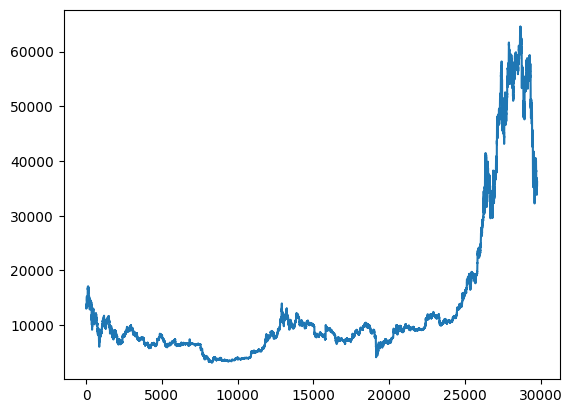

In [ ]:
plt.plot(df['close'])

In [25]:
def read_file(filename):
    return pd.read_csv(filename)

def get_data(timeframe):
    return read_file(r"C:\Users\ayush\Desktop\IITB\ZeltaLabPS\BackTesting\data\data\btcusdt_" + timeframe + "_total.csv")

time_frame = "1h"
# Load data
df = get_data(time_frame)
df.head()

datetime      open      high       low     close      volume
0  2018-01-01 05:30:00  13715.65  13715.65  13400.01  13529.01  443.356199
1  2018-01-01 06:30:00  13528.99  13595.89  13155.38  13203.06  383.697006
2  2018-01-01 07:30:00  13203.00  13418.43  13200.00  13330.18  429.064572
3  2018-01-01 08:30:00  13330.26  13611.27  13290.00  13410.03  420.087030
4  2018-01-01 09:30:00  13434.98  13623.29  13322.15  13601.01  340.807329

In [45]:
df['volatility'] = df['close'].rolling(window=10).std()
df['volatility'] = np.log(df['volatility'])

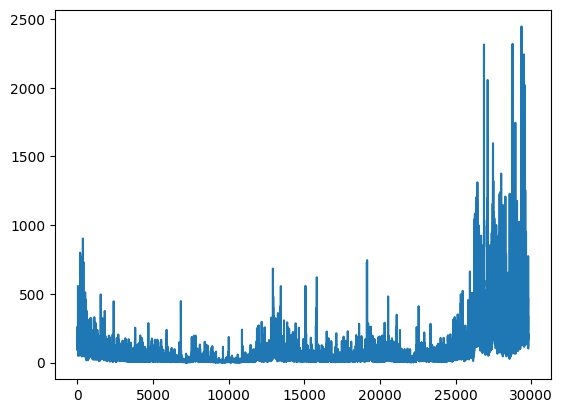

In [27]:
## Plot the volatility
plt.plot(df['volatility'])

In [31]:
def read_file(filename):
    return pd.read_csv(filename)

def get_data(timeframe):
    return read_file(r"C:\Users\ayush\Desktop\IITB\ZeltaLabPS\BackTesting\data\data\btcusdt_" + timeframe + "_val.csv")

time_frame = "1h"
# Load data
df2 = get_data(time_frame)
df2.head()

datetime     open     high      low    close       volume
0  2020-07-24 23:30:00  9557.66  9589.00  9556.00  9580.01  1927.603117
1  2020-07-25 00:30:00  9580.00  9583.80  9560.00  9581.76  1236.182213
2  2020-07-25 01:30:00  9581.76  9620.00  9567.23  9615.29  2119.244392
3  2020-07-25 02:30:00  9615.32  9637.00  9588.08  9591.55  2088.164018
4  2020-07-25 03:30:00  9591.55  9593.46  9522.00  9533.92  2069.404213

(array([1.203e+03, 2.820e+03, 2.965e+03, 2.696e+03, 2.253e+03, 1.725e+03,
        1.503e+03, 1.232e+03, 1.010e+03, 8.550e+02, 7.240e+02, 6.200e+02,
        5.680e+02, 5.630e+02, 4.360e+02, 4.260e+02, 3.690e+02, 3.460e+02,
        2.860e+02, 2.910e+02, 2.630e+02, 2.740e+02, 2.360e+02, 2.170e+02,
        1.700e+02, 1.860e+02, 1.830e+02, 1.880e+02, 1.730e+02, 1.400e+02,
        1.250e+02, 1.490e+02, 1.340e+02, 1.110e+02, 9.400e+01, 9.600e+01,
        1.180e+02, 1.150e+02, 9.200e+01, 1.060e+02, 8.100e+01, 7.700e+01,
        7.500e+01, 8.400e+01, 8.200e+01, 6.100e+01, 6.500e+01, 7.200e+01,
        7.600e+01, 6.900e+01, 6.700e+01, 5.500e+01, 7.100e+01, 7.300e+01,
        7.100e+01, 5.600e+01, 6.200e+01, 7.100e+01, 6.700e+01, 5.600e+01,
        4.900e+01, 5.100e+01, 6.000e+01, 3.900e+01, 4.400e+01, 4.800e+01,
        4.900e+01, 3.000e+01, 3.000e+01, 4.100e+01, 3.000e+01, 3.300e+01,
        3.100e+01, 3.400e+01, 4.000e+01, 3.500e+01, 4.200e+01, 5.000e+01,
        4.200e+01, 3.800e+01, 3.700e+0

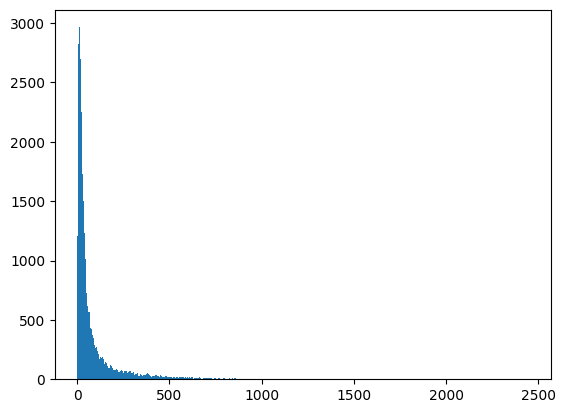

In [29]:
## Plot the histogram
plt.hist(df['volatility'], bins=500)

(array([  2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   1.,   1.,   1.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,
          1.,   2.,   3.,   2.,   0.,   1.,   0.,   4.,   0.,   1.,   1.,
          2.,   0.,   1.,   1.,   5.,   3.,   3.,   0.,   6.,   6.,   4.,
          1.,   1.,   5.,   4.,   3.,   6.,   2.,   3.,   4.,   4.,   0.,
         10.,   5.,   5.,   2.,   8.,   4.,   6.,   7.,   5.,   9.,   5.,
         15.,   9.,  10.,   8.,   3.,  21.,  13.,  19.,  19.,  16.,  10.,
         11.,  12.,  14.,  18.,  13.,  19.,  21.,  19.,  22.,  19.,  21.,
         33.,  27.,  28.,  29.,  33.,  23.,  24.,  29.,  29.,  32.,  28.,
         36.,  32.,  44.,  37.,  45.,  58.,  46.,  48.,  35.,  57.,  46.,
         47.,  45.,  53.,  50.,  63.,  66.,  61.,  48.,  63.,  57.,  52.,
         48.,  64.,  60.,  83.,  61., 

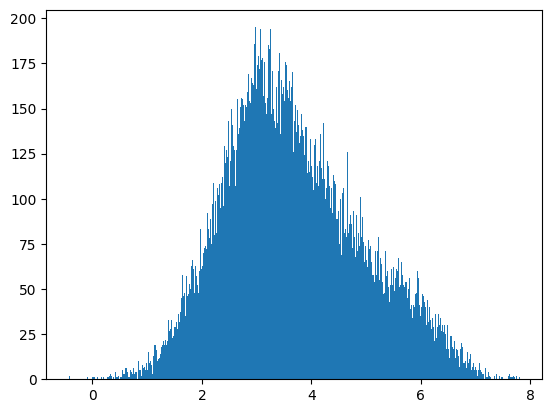

In [30]:
df['log_volatility'] = np.log(df['volatility'])
## Plot the histogram
plt.hist(df['log_volatility'], bins=500)

(array([ 1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  2.,  0.,
         3.,  1.,  1.,  3.,  1.,  1.,  0.,  1.,  3.,  1.,  1.,  0.,  2.,
         0.,  0.,  3.,  2.,  1.,  1.,  3.,  3.,  2.,  1.,  0.,  1.,  3.,
         3.,  0.,  4.,  0.,  1.,  3.,  0.,  6.,  3.,  2.,  4.,  3.,  7.,
         2.,  5.,  9., 11.,  8.,  9.,  6.,  5.,  3.,  9., 11., 11.,  7.,
         6.,  6.,  5.,  7., 12.,  8.,  3., 10., 11.,  9.,  4.,  3.,  8.,
        13., 10.,  6.,  3.,  8.,  9.,  9., 10., 13., 16.,  7.,  5.,  7.,
        17., 16., 17.,  9., 18.,  8., 11., 16., 16., 18., 15., 18., 12.,
        18., 14., 17., 14., 12., 19., 21., 10., 22., 18., 18., 20., 15.,
        15., 14.,  9., 13., 24., 13., 20., 14., 17., 13., 22., 17.,  7.,
        17., 13., 19., 12., 25., 11., 15., 17., 24., 16., 21., 16., 21.,
        24., 16., 19., 21., 21., 19., 20., 19., 21., 20., 15., 20., 21.,
        11., 10., 22., 11., 19., 20., 19., 24., 18.

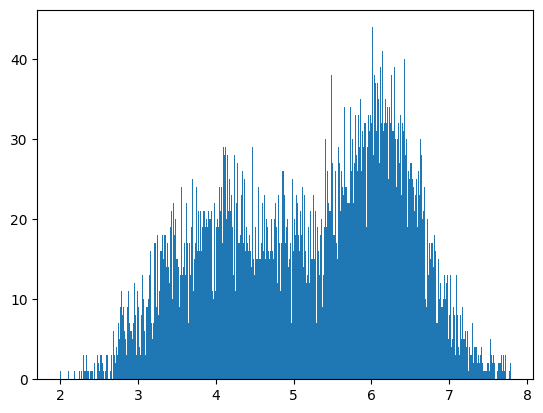

In [34]:
df2['log_volatility'] = np.log(df2['close'].rolling(window=10).std())
## Plot the histogram
plt.hist(df2['log_volatility'], bins=500)

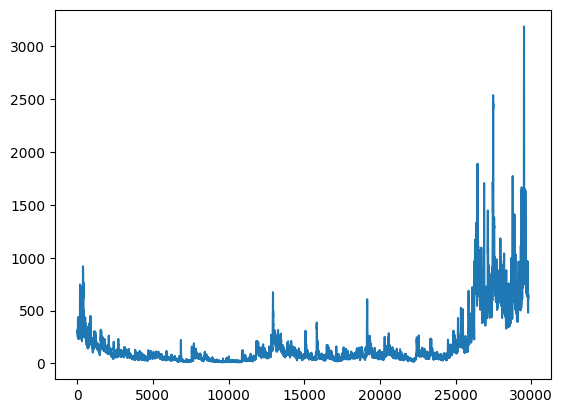

In [37]:
# Calculate True Range
df['high-low'] = df['high'] - df['low']
df['high-close'] = abs(df['high'] - df['close'].shift(1))
df['low-close'] = abs(df['low'] - df['close'].shift(1))
df['True Range'] = df[['high-low', 'high-close', 'low-close']].max(axis=1)

# Calculate ATR
period = 14  # You can adjust the period as needed
df['ATR'] = df['True Range'].rolling(window=period).mean()
df['log_ATR'] = np.log(df['ATR'])
# Drop intermediate columns
df.drop(['high-low', 'high-close', 'low-close', 'True Range'], axis=1, inplace=True)

# Print the DataFrame with ATR
plt.plot(df['ATR'])

(array([  1.,   0.,   1.,   0.,   0.,   0.,   0.,   3.,   0.,   0.,   2.,
          0.,   0.,   0.,   2.,   0.,   3.,   0.,   2.,   1.,   1.,   5.,
          2.,   5.,   5.,  12.,  11.,  11.,  17.,   7.,  13.,   9.,  16.,
         13.,  15.,   9.,  16.,  13.,  15.,  33.,   9.,  22.,  24.,  20.,
         24.,  26.,  33.,  31.,  29.,  27.,  23.,  32.,  30.,  37.,  27.,
         32.,  33.,  31.,  31.,  40.,  48.,  38.,  64.,  50.,  45.,  47.,
         49.,  69.,  48.,  56.,  54.,  53.,  45.,  44.,  39.,  59.,  51.,
         45.,  34.,  49.,  46.,  39.,  53.,  57.,  55.,  54.,  54.,  39.,
         58.,  50.,  44.,  46.,  52.,  55.,  55.,  47.,  57.,  64.,  61.,
         54.,  56.,  69.,  50.,  62.,  49.,  83.,  69.,  60.,  50.,  59.,
         54.,  49.,  58.,  69.,  62.,  74.,  85.,  80.,  79.,  91.,  65.,
         70.,  80.,  86.,  88.,  88., 104.,  89., 103.,  92., 102.,  95.,
         94., 107., 110., 117., 120., 107., 138., 132., 146., 147., 125.,
        152., 159., 156., 144., 151., 

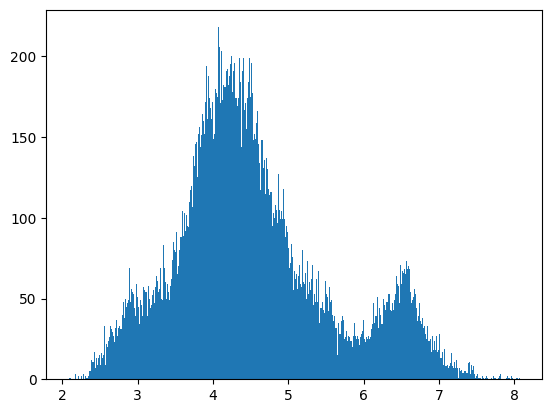

In [38]:
plt.hist(df['log_ATR'], bins=500)

In [39]:
def calculate_momentum(df, n=10):
    df['Momentum'] = df['close'] - df['close'].shift(n)
    df['Momentum'] = df['Momentum'] / df['close'].shift(n) * 100
    
    return df

def calculate_roc(df, n=10):
    df['ROC'] = (df['close'] - df['close'].shift(n)) / df['close'].shift(n)
    return df

def calculate_cci(df, n=20, factor=0.0015):
    typical_price = (df['high'] + df['low'] + df['close']) / 3
    sma = typical_price.rolling(window=n).mean()
    mean_deviation = (typical_price - sma).abs().rolling(window=n).mean()
    
    df['CCI'] = (typical_price - sma) / (factor * mean_deviation)
    
    return df

def calculate_rsi(data, close_column='close', period=14):
    """
    Calculate the Relative Strength Index (RSI) and add a new column to the DataFrame.

    Parameters:
    - data: DataFrame with OHLCV data
    - close_column: Name of the column representing closing prices (default is 'Close')
    - period: RSI calculation period (default is 14)

    Returns:
    - Modified DataFrame with an additional 'RSI' column
    """
    # Calculate daily price changes
    data['Price Change'] = data[close_column].diff()

    # Define the RSI period
    rsi_period = period

    # Calculate average gain and average loss
    data['Gain'] = data['Price Change'].apply(lambda x: x if x > 0 else 0)
    data['Loss'] = data['Price Change'].apply(lambda x: abs(x) if x < 0 else 0)

    avg_gain = data['Gain'].rolling(window=rsi_period).mean()
    avg_loss = data['Loss'].rolling(window=rsi_period).mean()

    # Calculate relative strength (RS)
    rs = avg_gain / avg_loss

    # Calculate RSI
    data['RSI'] = 100 - (100 / (1 + rs))

    # Drop intermediate columns
    data.drop(['Price Change', 'Gain', 'Loss'], axis=1, inplace=True)

    return data


In [40]:
df = calculate_momentum(df)
df = calculate_roc(df)
df = calculate_cci(df)
df = calculate_rsi(df)

In [42]:
def plot_histograms(df, columns, bins=200):
    num_columns = len(columns)
    
    # Create subplots
    fig, axs = plt.subplots(num_columns, 2, figsize=(10, 4*num_columns))
    fig.suptitle('Histograms and Log Histograms', y=1.02, fontsize=16)

    for i, column in enumerate(columns):
        # Plot histogram for original data
        axs[i, 0].hist(df[column], bins=bins, color='blue', alpha=0.7)
        axs[i, 0].set_title(f'Original {column} Histogram')
        axs[i, 0].set_xlabel(column)
        axs[i, 0].set_ylabel('Frequency')

        # Plot histogram for log-transformed data
        log_column = 'log_' + column
        df[log_column] = np.log(df[column] + 1)  # Adding 1 to avoid log(0)
        axs[i, 1].hist(df[log_column], bins=bins, color='orange', alpha=0.7)
        axs[i, 1].set_title(f'Log-transformed {column} Histogram')
        axs[i, 1].set_xlabel(f'log({column} + 1)')
        axs[i, 1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

c:\Users\ayush\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\ayush\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


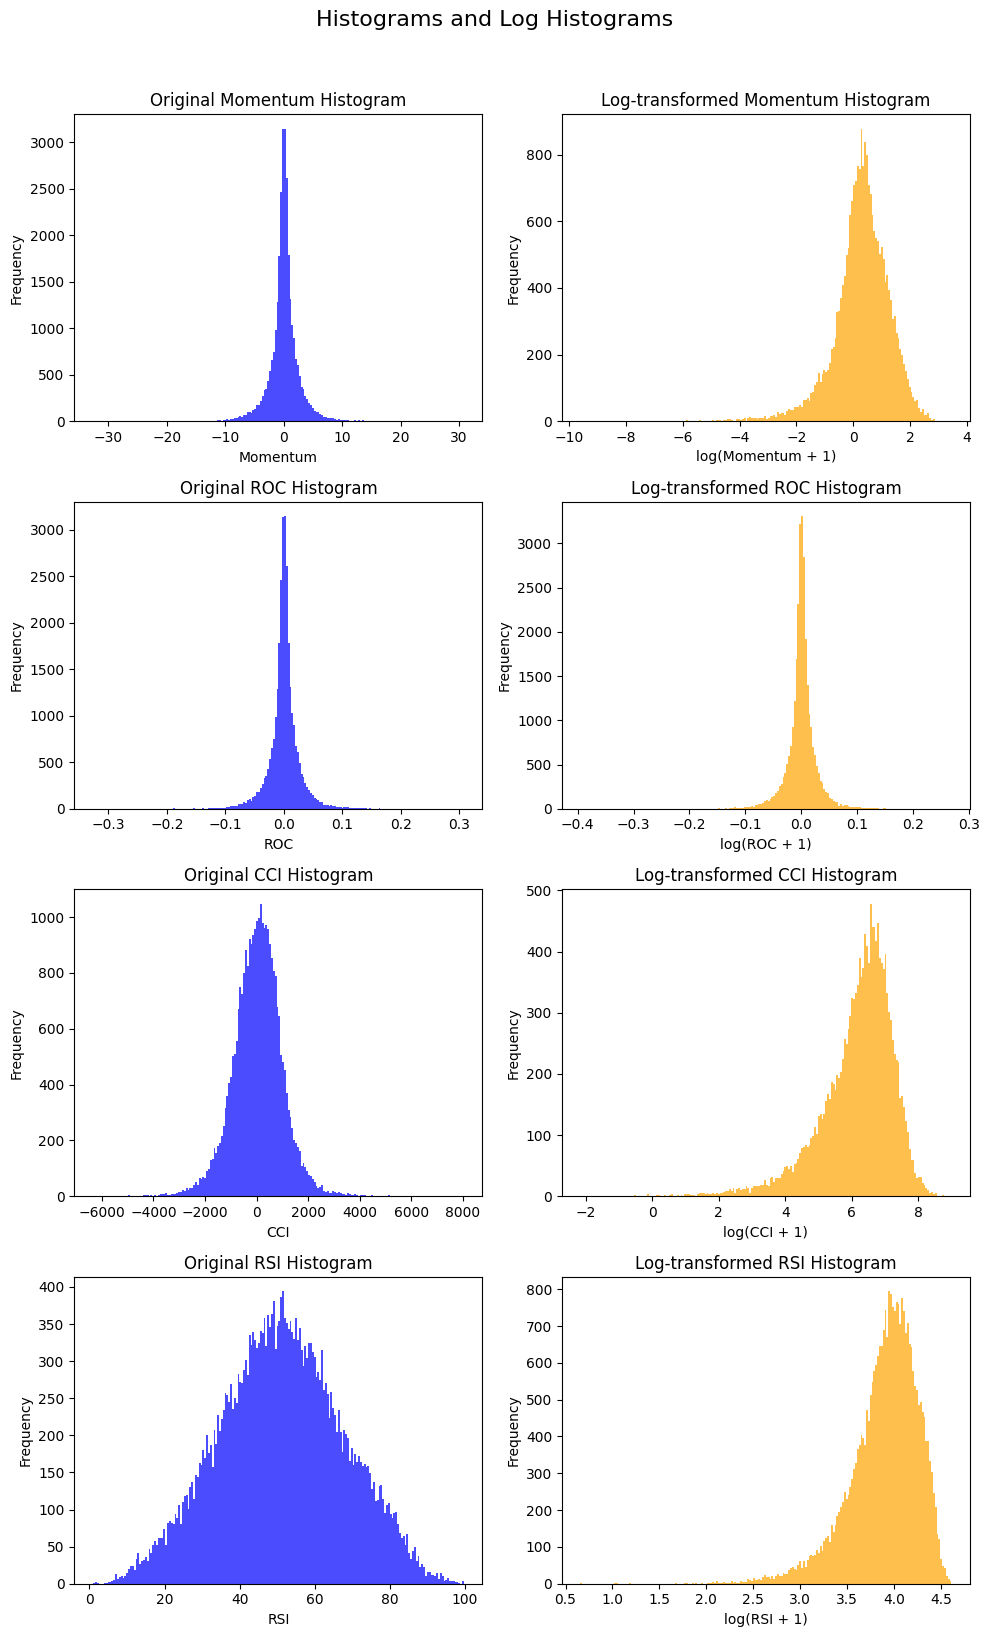

In [43]:
columns = ['Momentum', 'ROC', 'CCI', 'RSI']
plot_histograms(df, columns)

In [47]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline



# Shift the Close price to get the previous close
df['Prev Close'] = df['close']

# Shift the features to align with the next timestamp's Close
df['Next Close'] = df['close'].shift(-1)
df = df.dropna()  # Drop rows with NaN values

# Select features and target variable
features = ['RSI', 'CCI', 'Momentum', 'Prev Close', 'volatility']
target = 'Next Close'

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)
# Create a linear regression model
model = make_pipeline(StandardScaler(), LinearRegression())
# Fit the model to the training data
model.fit(X_train, y_train)
# Make predictions on the test set
predictions = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')




Mean Squared Error: 80071.3014952341
Predicted Next Close: 87.72985012722347


C:\Users\ayush\AppData\Local\Temp\ipykernel_21884\3851961322.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Prev Close'] = df['close']
C:\Users\ayush\AppData\Local\Temp\ipykernel_21884\3851961322.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Next Close'] = df['close'].shift(-1)
c:\Users\ayush\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [53]:
# Extracting the linear regression model from the pipeline
linear_regression_model = model.named_steps['linearregression']

# Extracting the coefficients (weights)
coefficients = linear_regression_model.coef_

# Creating a dictionary to map each feature name to its corresponding coefficient
feature_weights = dict(zip(features, coefficients))

# Display the weights for each feature
for feature, weight in feature_weights.items():
    print(f"{feature}: {weight}")

RSI: 3.416737613348531
CCI: 2.370348391967468
Momentum: -6.061970044701418
Prev Close: 13722.691143104576
volatility: 6.7818488470993765


In [54]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Create a Random Forest regressor
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model to the training data
random_forest_model.fit(X_train, y_train)

# Make predictions on the test set
rf_predictions = random_forest_model.predict(X_test)

# Evaluate the model
rf_mse = mean_squared_error(y_test, rf_predictions)
print(f'Random Forest Mean Squared Error: {rf_mse}')

# Feature Importance
feature_importance = random_forest_model.feature_importances_
feature_importance_dict = dict(zip(features, feature_importance))
print("Feature importances:")
for feature, importance in feature_importance_dict.items():
    print(f"{feature}: {importance}")

Random Forest Mean Squared Error: 93596.52753570798
Feature importances:
RSI: 4.40332102916679e-05
CCI: 3.566010909677725e-05
Momentum: 3.093611319433873e-05
Prev Close: 0.9998415780908758
volatility: 4.779247654146511e-05


In [49]:
df.head()

datetime      open      high       low     close       volume  \
47  2018-01-03 04:30:00  14799.97  14887.08  14600.00  14675.11   764.349881   
48  2018-01-03 05:30:00  14690.00  14926.22  14660.00  14774.53   661.468616   
49  2018-01-03 06:30:00  14758.01  14853.53  14660.00  14820.00   788.317514   
50  2018-01-03 07:30:00  14847.97  15119.90  14744.99  15008.07   822.858852   
51  2018-01-03 08:30:00  15008.07  15299.99  14750.00  14818.49  1031.188608   

    volatility  log_volatility         ATR   log_ATR   Momentum       ROC  \
47    6.279936        3.900355  389.105714  5.963851   5.842994  0.058430   
48    6.219438        3.976448  392.715714  5.973086   8.124250  0.081242   
49    6.103488        4.174245  394.257143  5.977003   8.253963  0.082540   
50    5.796531        4.797230  411.069286  6.018762  10.434495  0.104345   
51    4.728139        4.794648  421.455000  6.043713   7.536212  0.075362   

            CCI        RSI  log_Momentum   log_ROC   log_CCI   log_RSI  \
47  1368.911681  76.212009      1.923225  0.056787  7.222502  4.346555   
48  1243.697647  76.124206      2.210936  0.078111  7.126648  4.345417   
49  1042.037058  78.913043      2.225052  0.079310  6.949892  4.380939   
50  1081.853820  80.538054      2.436635  0.099252  6.987355  4.401070   
51   908.443918  70.721721      2.144317  0.072657  6.812833  4.272794   

    Prev Close  Next Close  
47    14675.11    14774.53  
48    14774.53    14820.00  
49    14820.00    15008.07  
50    15008.07    14818.49  
51    14818.49    15019.66

In [58]:
X, P, A, Q, B, U, R = kalman_init()

In [56]:
feature_importances = np.array([4.40332102916679e-05, 3.566010909677725e-05, 3.093611319433873e-05, 0.9998415780908758, 4.779247654146511e-05])
normalized_importances = feature_importances / np.sum(feature_importances)


In [59]:
df = kf.kalman_filter_run()

n: 7417


In [60]:
df['k_alpha1'] = pd.to_numeric(df['k_alpha1'], errors='coerce')


In [63]:
print_buckets(df, ['k_alpha1'], rets, aggfunc)
print_corrs(df, ['k_alpha1'], rets)

                           mean                         median            \
                          ret_1    ret_10     ret_5      ret_1    ret_10   
k_alpha1                                                                   
(-2405.684, -239.004] -1.791575  0.218656 -1.804170  -5.279216  0.570231   
(-239.004, -108.792]   6.198753  3.666505  2.192860   1.241821  2.079190   
(-108.792, -47.708]    2.229653  2.818403  2.930094  -0.712521  1.532973   
(-47.708, -19.407]     3.457319  3.451028  1.917692  -2.690514  0.992708   
(-19.407, -4.717]      1.262422  1.643979  1.871247   0.012942  1.431266   
(-4.717, 8.251]        1.536321  2.073451  1.452955   2.504176  2.288854   
(8.251, 28.978]        3.283253  1.319997  0.608942   5.451040  2.540455   
(28.978, 83.001]      -0.134618  1.502839  2.533796   7.176081  2.833494   
(83.001, 212.533]      0.879543  0.767269  1.871595   1.819608  3.012408   
(212.533, 2406.887]    4.887245  0.671636  4.891052  17.628295  4.010796   

           

In [64]:
msg = df.pivot_table(index = pd.qcut(df['kalman_err'],10,duplicates='drop'), values=rets, aggfunc=aggfunc)


In [65]:
msg

mean                        median  \
                                    ret_1    ret_10     ret_5     ret_1   
kalman_err                                                                
(34.144000000000005, 17004.667]  1.269883  2.723882  2.789735  0.966614   
(17004.667, 48191.91]            3.659135  2.992543  2.504324  1.778409   
(48191.91, 95124.647]           -2.913927  1.119382  1.808064  1.630226   
(95124.647, 163244.706]          5.006785  2.495537  1.472129  2.828385   
(163244.706, 259021.593]         0.922299  2.218815  1.983053  0.393364   
(259021.593, 397987.34]          7.122460  2.654943  1.626966  4.523931   
(397987.34, 628233.152]         -1.015535  1.305464  0.058038 -0.992713   
(628233.152, 1084657.043]        9.139655  1.747889  3.398521  6.568585   
(1084657.043, 2596234.792]      -7.597949 -1.125887  0.028954  3.115857   
(2596234.792, 292879845.447]     6.228606  2.000020  2.796168  7.255696   

                                                    count               
                                   ret_10     ret_5 ret_1 ret_10 ret_5  
kalman_err                                                              
(34.144000000000005, 17004.667]  2.184718  2.106943   742    742   742  
(17004.667, 48191.91]            2.272329  1.452353   742    742   742  
(48191.91, 95124.647]            1.725363  1.459513   741    741   741  
(95124.647, 163244.706]          2.339583  2.398492   742    742   742  
(163244.706, 259021.593]         3.193990  1.871767   742    742   742  
(259021.593, 397987.34]          3.349863  1.828528   741    741   741  
(397987.34, 628233.152]          1.842278  0.850739   742    742   742  
(628233.152, 1084657.043]        2.127854  3.456938   741    741   741  
(1084657.043, 2596234.792]       0.992083  1.919806   742    742   742  
(2596234.792, 292879845.447]     1.618294  3.687024   742    742   742

In [66]:
df['k_a1'] = df['kalman1'] - df['close']


In [99]:
df['flag1'] = np.where(df['k_a1'] > 70, 1, 0) 


In [76]:
df['flag1'] = np.where(df['k_alpha1'] > 700, 1, 0) 

i = 0
n = len(df)
compare = 0
while i < n:
    if df.loc[i, 'flag1'] == 1 and compare == 0:
        df.loc[i, 'signal'] = 1
        compare = 1
        i = i + 1
    elif df.loc[i, 'flag1'] == 1 and compare == 1:  
        df.loc[i , 'signal'] = 0
        i = i + 1
    elif df.loc[i, 'flag1'] == 0 and compare == 1:
        df.loc[i, 'signal'] = -1
        compare = 0
        i = i + 1
    else:
        df.loc[i, 'flag1'] = 0
        i+=1

In [77]:
df['signal'] = df['signal'] * -1

In [98]:
df.to_csv(r'C:\Users\ayush\Desktop\IITB\ZeltaLabPS\BackTesting\src\logs\k_6.csv')

In [96]:
df['logs'] = np.nan

disable_trading = 0
stop_loss = 0
compare = 0
thresh = -0.02
for i in range(len(df)):
    if df["flag"].iloc[i] == 1 and compare == 0:
        # No open trade, encouter buy singal
        stop_loss = 0
        buy_price = df["open"].iloc[i]
        
        compare = 1
        df["logs"].iloc[i] = 1


    elif (df["flag"].iloc[i] != -1 and compare == 1):
        # Current buy trade, encounter buy signal or no signal - do nothing, update stop loss
        df["logs"].iloc[i] = 0

        #calculate pnl, if we exit now
        sell_price = df["open"].iloc[i]
        exit_loss = (sell_price - buy_price)/buy_price 
        stop_loss = min(stop_loss, exit_loss)

        #exit trade, if the loss is higher than stop loss
        if stop_loss < thresh and disable_trading == 0:
            df["logs"].iloc[i] = -1
            # print(f"disable_trading in buy trade - stop loss: {disable_trading}")
            disable_trading = 1


    elif df["flag"].iloc[i] == -1 and compare == 1:
        # Current buy trade, encounter sell signal

        #exit trade
        df["logs"].iloc[i] = -1
        compare = 0
        stop_loss = 0

        #if trade was already exited before, check for disable trading flag here, do nothing here
        if disable_trading == 1:
            disable_trading = 0
            # print(f"disable_trading in buy trade - while exiting: {disable_trading}")
            df["logs"].iloc[i] = 0



    elif df["flag"].iloc[i] == -1 and compare == 0:
        # No open trade, enounter sell siganl 
        stop_loss = 0
        sell_price = df["open"].iloc[i]
        
        compare = -1
        df["logs"].iloc[i] = -1


    elif (df["flag"].iloc[i] != 1 and compare == -1):
        # Current sell trade, encounter sell signal or no signal - do nothing, update stop loss
        df["logs"].iloc[i] = 0

        #calculate pnl, if we exit now
        buy_price = df["open"].iloc[i]
        exit_loss = (sell_price - buy_price)/sell_price 
        stop_loss = min(stop_loss, exit_loss)

        #exit trade, if the loss is higher than stop loss
        if stop_loss < thresh and disable_trading == 0:
            df["logs"].iloc[i] = 1
            # print(f"disable_trading in sell trade - stop loss: {disable_trading}")
            # print(i)
            disable_trading = 1

    elif df["flag"].iloc[i] == 1 and compare == -1:
        # 
        # print("Current sell trade, encounter buy signal")
        # print(f"{disable_trading}")

        #exit trade
        df["logs"].iloc[i] = 1
        compare = 0
        stop_loss = 0

        #if trade was already exited before, check for disable trading flag here, do nothing here
        if disable_trading == 1:
            # print("Check")
            disable_trading = 0
            df["logs"].iloc[i] = 0

    elif df["flag"].iloc[i] == 0 and compare == 0:
        df["logs"].iloc[i] == 0


# Fill in any missing values in the new column with 0.
df['logs'].fillna(0, inplace=True)

#close out positions (if needed)

df["logs"].iloc[-1] = -np.sum(df["logs"])

C:\Users\ayush\AppData\Local\Temp\ipykernel_21884\583238111.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["logs"].iloc[i] = 1
C:\Users\ayush\AppData\Local\Temp\ipykernel_21884\583238111.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["logs"].iloc[i] = 0
C:\Users\ayush\AppData\Local\Temp\ipykernel_21884\583238111.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["logs"].iloc[i] = -1
C:\Users\ayush\AppData\Local\T

In [97]:
df['signal'] = df['logs']